In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os

%matplotlib inline

PRONTO_DATA_PATH = r"D:\userdata\anliu\Desktop\Pronto"
FILENAME = "test.csv"

def csv_prepare(file, comment="Problem ID"):
    nrow = 0
    with open(file,"r") as f:
        for line in f:
            nrow = nrow + 1
            if line.startswith(comment): 
                return nrow-1
            
def load_pronto_data(pronto_file_path=PRONTO_DATA_PATH, pronto_file_name=FILENAME):
    file = os.path.join(pronto_file_path, pronto_file_name)
    csv_data = pd.read_csv(file, parse_dates=['Reported Date'], 
                           date_parser=lambda dates:[pd.datetime.strptime(d,"%d.%m.%Y") for d in dates],
                           skiprows=csv_prepare(file), index_col=['Reported Date'])
    return csv_data    

In [2]:
pronto_data = load_pronto_data()
pronto_data.shape

(1282, 9)

In [3]:
pronto_data.drop("Title", axis=1, inplace=True)
pronto_data.head()

,Problem ID,Problem Type,Group in Charge,Author Group,State,Severity,R&D Priority,Reported By
Reported Date,,,,,,,,
2017-01-01,PR206076,Software,RABLTESWUIROAM,LTE_FV_ET_ST_OAM1_HZ,Closed,B - Major,2 - Critical,Nokia
2017-01-03,PR206252,Software,TRS_ODYSSEY,LTE_FV_ET_ST_TRS_SEC_HZ,Closed,B - Major,3 - Normal,Nokia
2017-01-03,PR206278,Software,LTE_GVE_ET_ST_SISO3_HZ,LTE_GVE_ET_ST_SISO3_HZ,Closed,B - Major,3 - Normal,Nokia
2017-01-03,PR206321,Software,LTE_GVE_ET_ST_PET2_HZ,LTE_GVE_ET_ST_PET2_HZ,Closed,B - Major,2 - Critical,Nokia
2017-01-03,PR206329,Software,NIOSUB,LTE_GVE_ET_ST_SISO2_HZ,Closed,B - Major,3 - Normal,Nokia


In [4]:
pronto_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1282 entries, 2017-01-01 to 2017-05-16
Data columns (total 8 columns):
Problem ID         1282 non-null object
Problem Type       1282 non-null object
Group in Charge    1282 non-null object
Author Group       1282 non-null object
State              1282 non-null object
Severity           1282 non-null object
R&D Priority       1282 non-null object
Reported By        1282 non-null object
dtypes: object(8)
memory usage: 90.1+ KB


In [5]:
pronto_data.groupby("Author Group").size()

Author Group
LTE_DEVHZ1_CHZ_FV           27
LTE_DEVHZ2_CHZ_FV           45
LTE_DEVHZ3_CHZ_FV          102
LTE_DEVHZ5_CHZ_FV           59
LTE_DEVHZD_GUL_PHYTEST       8
LTE_FV_ET_ST_OAM1_HZ        54
LTE_FV_ET_ST_OAM2_HZ        26
LTE_FV_ET_ST_OAM3_HZ        47
LTE_FV_ET_ST_RRM1_HZ        13
LTE_FV_ET_ST_RRM2_HZ        19
LTE_FV_ET_ST_RRM3_HZ        17
LTE_FV_ET_ST_TA_CRT_HZ       2
LTE_FV_ET_ST_TRS_SEC_HZ     40
LTE_GVE_ET_ST_HFV1_HZ       80
LTE_GVE_ET_ST_HFV2_HZ       98
LTE_GVE_ET_ST_PET1_HZ       92
LTE_GVE_ET_ST_PET2_HZ       78
LTE_GVE_ET_ST_PET3_HZ       84
LTE_GVE_ET_ST_SISO1_HZ      64
LTE_GVE_ET_ST_SISO2_HZ      98
LTE_GVE_ET_ST_SISO3_HZ      85
LTE_GVE_ST_FIVE_HZ         142
NIHZSIVTDLTE15               2
dtype: int64

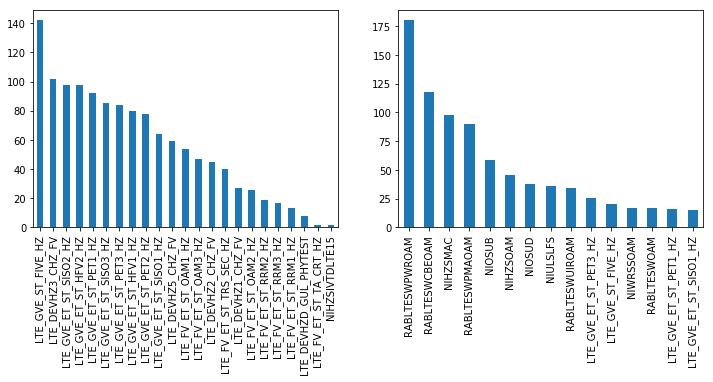

In [6]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
# author_group = pronto_data.groupby("Author Group").size()
# author_group.plot(kind='bar')
pronto_data['Author Group'].value_counts().plot(kind='bar')
ax2 = fig.add_subplot(122)
# group_in_charge = pronto_data.groupby("Group in Charge").size().nlargest(15)
# group_in_charge.plot(kind='bar')
pronto_data['Group in Charge'].value_counts().nlargest(15).plot(kind='bar')

In [7]:
pronto_data_closed = pronto_data[(pronto_data['State']=='Closed') | (pronto_data['State']=='Correction Not Needed')
                                | (pronto_data['State']=='Postponed')]['State'].to_frame()
pronto_data_new = pronto_data[pronto_data['State'] == 'New']['State'].to_frame()
pronto_data_ongoing = pronto_data[(pronto_data['State']!='Closed') & (pronto_data['State']!='Correction Not Needed') 
                                  & (pronto_data['State']!='New')]['State'].to_frame()

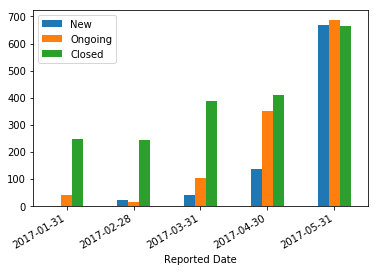

In [8]:
pronto_data_state = pd.merge(pronto_data_new, pronto_data_ongoing, how='outer', left_index=True, right_index=True, )
pronto_data_state = pd.merge(pronto_data_state, pronto_data_closed, how='outer', left_index=True, right_index=True)
pronto_data_state.rename(columns={'State_x':'New', 'State_y':'Ongoing', 'State':'Closed'}, inplace=True)
pronto_data_state = pronto_data_state.resample('M').count()
ax = pronto_data_state.plot(kind='bar', stacked=False)
# pronto_data_state.plot(kind='line', stacked=False)
# DataFrame.plot overrides previous plots if the frame's index is DatetimeIndex 
# https://github.com/pandas-dev/pandas/issues/10761
ticklabels = [item.strftime('%Y-%m-%d') for item in pronto_data_state.index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()

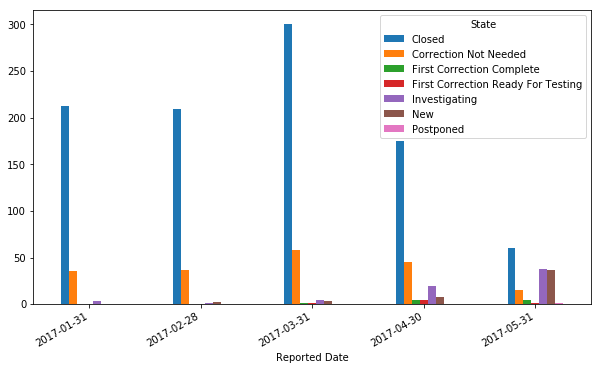

In [9]:
pr_state_group = pronto_data.groupby('State').resample('M').size().unstack('State')
ax = pr_state_group.plot(kind='bar',figsize=(10,6))
ticklabels = [item.strftime('%Y-%m-%d') for item in pr_state_group.index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()